In [42]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from tpot import TPOTClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Set seed for reproducibility
np.random.seed(42)
set_seed(42)

In [44]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['open', 'high', 'low', 'adj_close'], inplace=True)     # Colinear features observed from EDA notebook
df.head()

,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,
2000-01-03,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


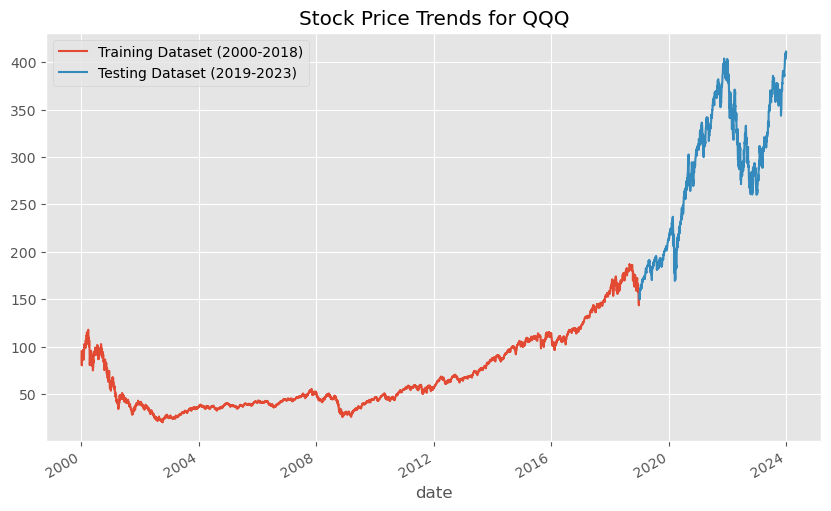

In [45]:
df['close'][:'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

In [46]:
train = df[df.index <= '2018-12-31']
test = df[df.index > '2018-12-31']

In [47]:
X_train  = train.reset_index()
X_train.drop(columns=['date', 'close'], inplace=True)
display(X_train.head())

X_test  = test.reset_index()
X_test.drop(columns=['date', 'close'], inplace=True)
display(X_test.head())

,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,36345200,5.43,7.5,2.826171,4.1,111.3
1,33786600,5.38,7.5,2.826171,4.1,111.3
2,42496600,5.41,7.5,2.826171,4.1,111.3
3,37134800,5.54,7.5,2.826171,4.1,111.3
4,28138200,5.61,7.5,2.826171,4.1,111.3


,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,58576700,2.4,3.4,1.233584,3.8,93.8
1,74820200,2.4,3.4,1.233584,3.8,93.8
2,74709300,2.4,3.4,1.233584,3.8,93.8
3,52059300,2.4,3.4,1.233584,3.8,93.8
4,49388700,2.4,3.4,1.233584,3.8,93.8


In [48]:
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

In [49]:
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [50]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Linear Regression": LinearRegression(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [51]:
test_regression_models(X_train_scaled, y_train)

,Model,Mean Squared Error,Spread (std),Train Time (s),Memory Usage (MB)
0,Linear Regression,1443.1902,1629.9934,0.0459,625.0
1,K-Nearest Neighbors,681.0830,968.1471,0.1926,625.0
2,Decision Tree,1809.2469,2229.9879,0.4731,625.0
3,Random Forest,1583.2468,2267.3146,33.0806,624.0
4,Gradient Boosting,1147.2363,2062.9006,9.0468,624.0
5,XGBoost,1443.2812,2204.5573,1.0414,631.0
6,Support Vector Regressor,761.3741,1391.4371,14.7763,622.0


Best performing model was the KNN. Let's see if we can boost performance.

___

___

### KNN

In [52]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 7, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [1,2],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

In [53]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=True)

In [54]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [3, 7, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [55]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsRegressor(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [56]:
best_score = grid_search.best_score_
best_score

-4.590323358902087

In [57]:
best_knn_pred = best_knn.predict(X_test_scaled)

In [58]:
best_knn_r2 = r2_score(y_test, best_knn_pred)
best_knn_r2

-11.617642506142317

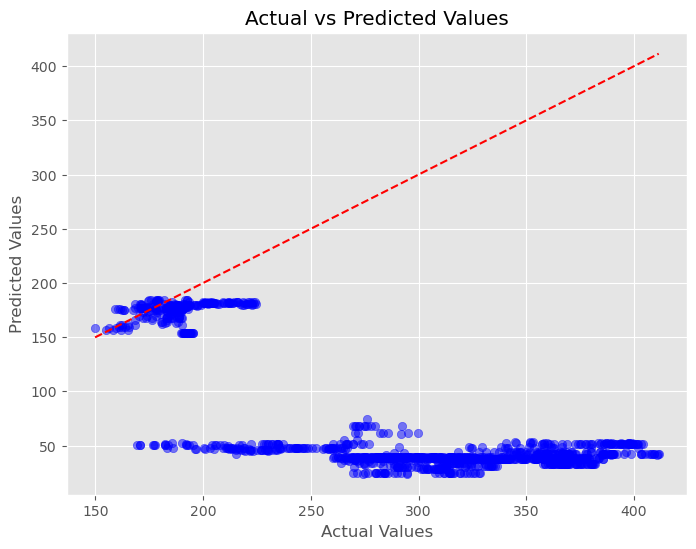

In [59]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_knn_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show()


Interpretation:

Even best KNN is unable to perform well on predictive task.

___

In [60]:
X_train_scaled.shape

(4779, 6)

In [61]:
# Function to create window for given timesteps
def create_window(data, target, timesteps):
    X, y = [], []
    for i in range (timesteps, len(data)):
        X.append(data[i-timesteps: i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [62]:
# Fit to scaled data with timesteps=30
X_train_rnn, y_train_rnn = create_window(X_train_scaled, y_train, 30)
X_test_rnn, y_test_rnn = create_window(X_test_scaled, y_test, 30)

In [63]:
# Used to moderate training and validation time
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

In [ ]:
simple_rnn = Sequential()

simple_rnn.add(SimpleRNN(units=50,
                         input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                         return_sequences=False))
simple_rnn.add(Dense(1))

simple_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 30, 50)            2850      
                                                                 
 dense_8 (Dense)             (None, 30, 1)             51        
                                                                 
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


In [78]:
simple_rnn.compile(optimizer='adam', loss='mean_squared_error')

simple_rnn_history = simple_rnn.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 3s 11ms/step - loss: 5189.3491 - val_loss: 82342.3438
Epoch 2/30
149/149 [==============================] - 1s 8ms/step - loss: 4202.6504 - val_loss: 78189.8203
Epoch 3/30
149/149 [==============================] - 1s 8ms/step - loss: 3525.5964 - val_loss: 74584.5391
Epoch 4/30
149/149 [==============================] - 1s 8ms/step - loss: 2999.0286 - val_loss: 71378.6484
Epoch 5/30
149/149 [==============================] - 1s 8ms/step - loss: 2592.0872 - val_loss: 68506.1797
Epoch 6/30
149/149 [==============================] - 1s 8ms/step - loss: 2282.7781 - val_loss: 66003.0469
Epoch 7/30
149/149 [==============================] - 1s 8ms/step - loss: 2053.4329 - val_loss: 63820.3125
Epoch 8/30
149/149 [==============================] - 1s 9ms/step - loss: 1888.5803 - val_loss: 61929.1484
Epoch 9/30
149/149 [==============================] - 1s 8ms/step - loss: 1773.5892 - val_loss: 60353.1484
Epoch 10/30
149/149 [===============

In [66]:
# Function to plot Loss by Epoch
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss by Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

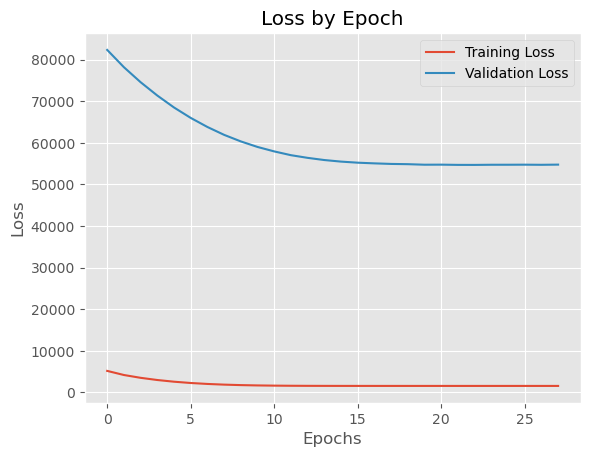

In [79]:
# Simple RNN
plot_loss(simple_rnn_history)

Despite a steady decline in loss for the training function, the model is still failiing to perform on well on test data. Minimum validation loss is around 55k.

Let's try LSTM

In [ ]:
lstm = Sequential()

lstm.add(LSTM(units=50,
              input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
              return_sequences=False))
lstm.add(Dense(1))
lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 50)            11400     
                                                                 
 dense_9 (Dense)             (None, 30, 1)             51        
                                                                 
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [81]:
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm_history = lstm.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 7s 24ms/step - loss: 5174.8682 - val_loss: 81478.1562
Epoch 2/30
149/149 [==============================] - 2s 16ms/step - loss: 4021.8152 - val_loss: 77080.6016
Epoch 3/30
149/149 [==============================] - 2s 17ms/step - loss: 3352.8394 - val_loss: 73437.0000
Epoch 4/30
149/149 [==============================] - 3s 19ms/step - loss: 2852.8772 - val_loss: 70266.5391
Epoch 5/30
149/149 [==============================] - 3s 22ms/step - loss: 2478.1165 - val_loss: 67466.2812
Epoch 6/30
149/149 [==============================] - 3s 21ms/step - loss: 2199.7693 - val_loss: 65053.7969
Epoch 7/30
149/149 [==============================] - 4s 25ms/step - loss: 1997.2523 - val_loss: 62969.6211
Epoch 8/30
149/149 [==============================] - 3s 21ms/step - loss: 1854.3883 - val_loss: 61181.0156
Epoch 9/30
149/149 [==============================] - 3s 20ms/step - loss: 1756.6587 - val_loss: 59712.4023
Epoch 10/30
149/149 [=======

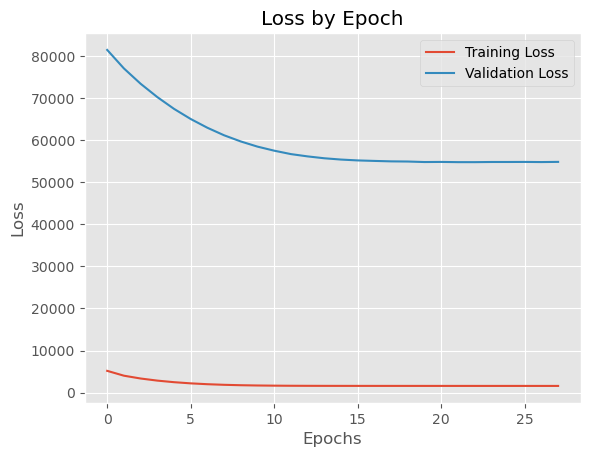

In [82]:
# LSTM
plot_loss(lstm_history)

Minimum validation loss near 55k. Let's take a look at GRU

In [ ]:
gru = Sequential()

gru.add(GRU(units=50,
            input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
            return_sequences=False))
gru.add(Dense(1))
gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 50)            8700      
                                                                 
 dense_7 (Dense)             (None, 30, 1)             51        
                                                                 
Total params: 8,751
Trainable params: 8,751
Non-trainable params: 0
_________________________________________________________________


In [76]:
gru.compile(optimizer='adam', loss='mean_squared_error')
gru_history = gru.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 7s 23ms/step - loss: 5074.2021 - val_loss: 80977.3516
Epoch 2/30
149/149 [==============================] - 3s 18ms/step - loss: 3953.0618 - val_loss: 76774.5312
Epoch 3/30
149/149 [==============================] - 3s 19ms/step - loss: 3304.2842 - val_loss: 73191.2656
Epoch 4/30
149/149 [==============================] - 3s 19ms/step - loss: 2812.7212 - val_loss: 70044.3359
Epoch 5/30
149/149 [==============================] - 3s 19ms/step - loss: 2440.5249 - val_loss: 67245.5938
Epoch 6/30
149/149 [==============================] - 3s 22ms/step - loss: 2163.0012 - val_loss: 64830.4414
Epoch 7/30
149/149 [==============================] - 3s 19ms/step - loss: 1961.8083 - val_loss: 62746.9180
Epoch 8/30
149/149 [==============================] - 3s 21ms/step - loss: 1821.0735 - val_loss: 60963.6602
Epoch 9/30
149/149 [==============================] - 3s 20ms/step - loss: 1725.9330 - val_loss: 59504.3789
Epoch 10/30
149/149 [=======

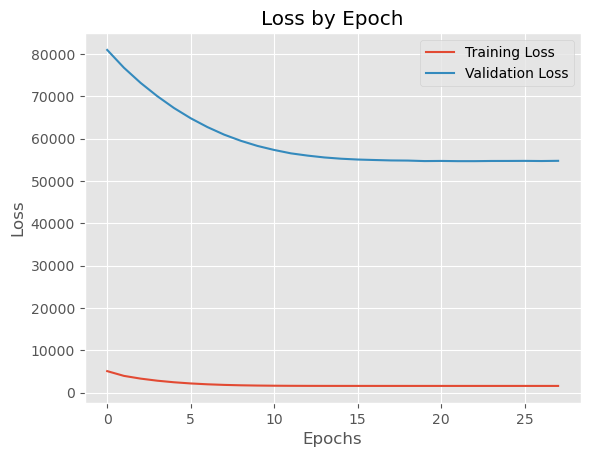

In [83]:
plot_loss(gru_history)

Minimum validation loss near 58k

The simple RNN and LSTM had the best baseline performance. Because LSTM is better with more complex data I'll continue building that out to further reduce validation loss.

In [84]:
best_rnn = Sequential()

# Layer 1
best_rnn.add(LSTM(units=128,
                  input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                  return_sequences=True))
best_rnn.add(Dropout(0.20))

# Layer 2
best_rnn.add(LSTM(units=128,
                  return_sequences=True))
best_rnn.add(Dropout(0.20))

# Layer 3
best_rnn.add(LSTM(units=128,
                  return_sequences=False))
best_rnn.add(Dropout(0.20))

# Output Layer
best_rnn.add(Dense(1))
best_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)               

In [ ]:
best_rnn.compile(optimizer='adam', loss='mean_squared_error')
best_rnn_history = best_rnn.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 20s 80ms/step - loss: 1587.5586 - val_loss: 54684.2422
Epoch 2/30
149/149 [==============================] - 10s 68ms/step - loss: 1589.1903 - val_loss: 57273.1602
Epoch 3/30
149/149 [==============================] - 10s 69ms/step - loss: 1593.4965 - val_loss: 54857.5586
Epoch 4/30
149/149 [==============================] - 12s 83ms/step - loss: 1588.5544 - val_loss: 55168.0312
Epoch 5/30
149/149 [==============================] - 12s 83ms/step - loss: 1587.4158 - val_loss: 54929.4531
Epoch 6/30
149/149 [==============================] - 13s 85ms/step - loss: 1590.8558 - val_loss: 54853.0508


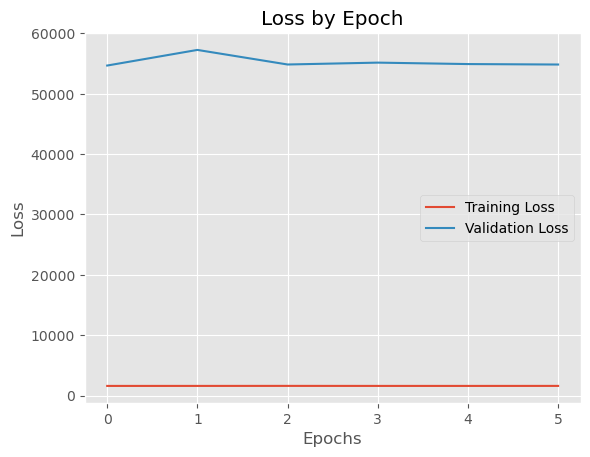

In [93]:
plot_loss(best_rnn_history)

39/39 [==============================] - 3s 23ms/step


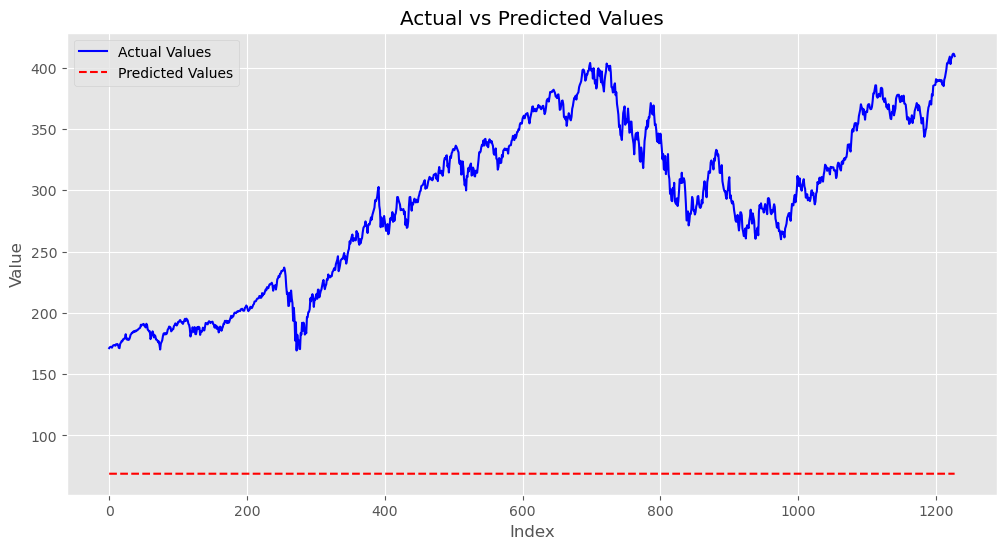

In [88]:
# Get predictions from the model
best_rnn_pred = best_rnn.predict(X_test_rnn)

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_rnn, label="Actual Values", color='blue')
plt.plot(best_rnn_pred, label="Predicted Values", color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()
